# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0
!pip install xgboost

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/data/train.csv'
test_path  = '/data/ephemeral/home/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [5]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [8]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 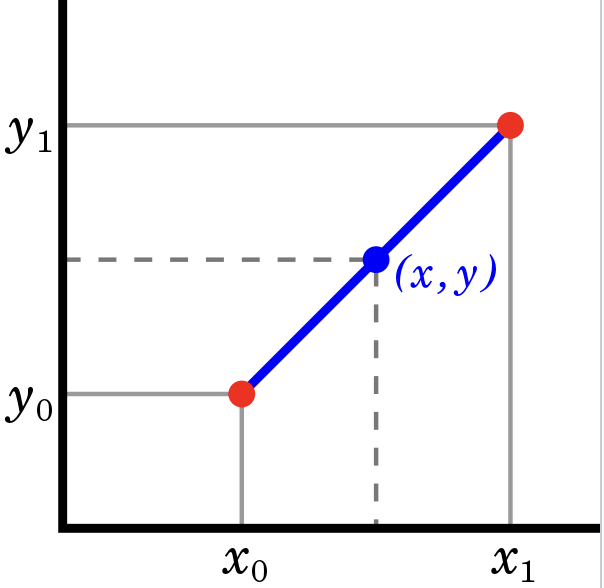

In [9]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [10]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [11]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [12]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [13]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

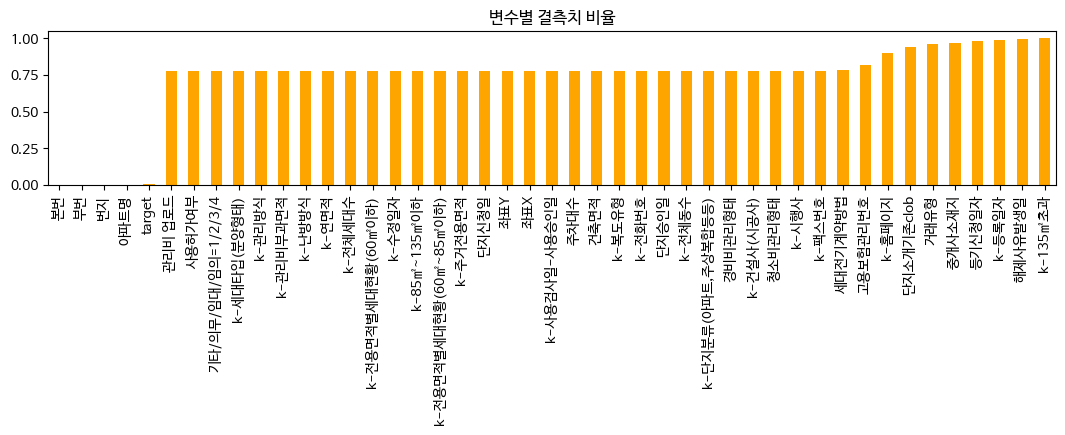

In [14]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [15]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [16]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [17]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [18]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [19]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [20]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [21]:
# 이산형과 연속형 변수 분리
# 이산형 변수 목록
discrete_vars = ['계약년월', '계약일', '층', '건축년도', 'k-전체동수', 
                 'k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 
                 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 
                 '주차대수', 'is_test']

# 이산형 변수 추출 및 저장
discrete_columns = [col for col in continuous_columns if col in discrete_vars]

# 이산형 변수 제거 후 연속형 변수 리스트 업데이트
continuous_columns = [col for col in continuous_columns if col not in discrete_vars]

# 좌표 정보는 선형 보간에서 제외
del continuous_columns[-2]
del continuous_columns[-2]

# 결과 확인
print("이산형 변수: ", discrete_columns)
print("연속형 변수: ", continuous_columns)

이산형 변수:  ['계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '주차대수', 'is_test']
연속형 변수:  ['전용면적', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', 'target']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [22]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

# 이산형 변수에 대한 보간
for col in discrete_columns:
    if concat_select[col].isnull().any():  # 결측치가 있는 경우만 처리
        mode_value = concat_select[col].mode()[0]  # 최빈값 계산
        concat_select[col].fillna(mode_value, inplace=True)  # 결측치 대체


In [23]:
# 결측치 제거를 위해 시군구, 계약년월 미리 분리

# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [24]:
# 좌표값 결측치 동 좌표값으로 대체
dong_path = '서울시_행정동_좌표.csv'
dong_df = pd.read_csv(dong_path)

# dong_df에서 'dong'을 기준으로 좌표 딕셔너리 생성
lat_dict = dong_df.set_index('dong')['lat'].to_dict()
lng_dict = dong_df.set_index('dong')['lng'].to_dict()

# '좌표X'와 '좌표Y'가 결측치인 경우 'lat', 'lng' 값으로 대체
concat_select['좌표X'] = concat_select['좌표X'].fillna(concat_select['동'].map(lat_dict))
concat_select['좌표Y'] = concat_select['좌표Y'].fillna(concat_select['동'].map(lng_dict))

# 결과 확인
print(concat_select[['동', '좌표X', '좌표Y']].head())

     동        좌표X        좌표Y
0  개포동  127.05721  37.476763
1  개포동  127.05721  37.476763
2  개포동  127.05721  37.476763
3  개포동  127.05721  37.476763
4  개포동  127.05721  37.476763


In [25]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일               

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

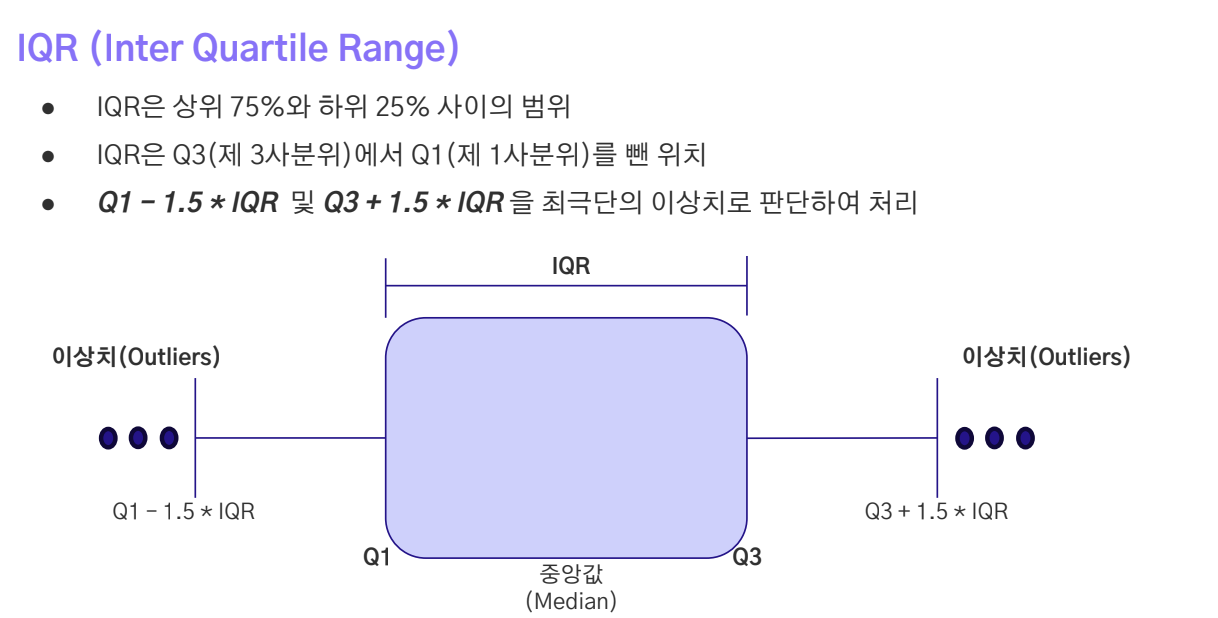

In [26]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 47)


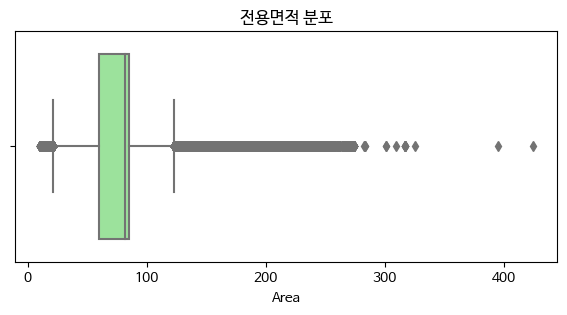

In [27]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [28]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [29]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')
# concat_select = remove_outliers_iqr(concat_select, '층')
# concat_select = remove_outliers_iqr(concat_select, 'target')

In [30]:
# # 층, 가격 이상치 제거
# concat_select = concat_select[
#     ~((concat_select['is_test'] == 0) & 
#       ((concat_select['층'] > 50) | (concat_select['target'] > 510000)))
# ]

In [31]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 47)


In [32]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.(1038846, 45)

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [33]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [34]:
concat_select['k-주거전용면적']

0       20204.0
1       20204.0
2       20204.0
3       20204.0
4       20204.0
         ...   
9267    93849.0
9268    93849.0
9269    93849.0
9270    93849.0
9271    93849.0
Name: k-주거전용면적, Length: 1038846, dtype: float64

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [35]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [36]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [37]:
# 전용면적 범주화
bins = [0, 60, 85, 135, np.inf]
labels = ['소형', '중형', '대형', '초대형']
concat_select['평형대'] = pd.cut(concat_select['전용면적'], bins=bins, labels=labels)

In [38]:
# # 재건축 가능성 추가
# concat_select['건축연차'] = 2024 - concat_select['건축년도']
# concat_select['재건축가능'] = (concat_select['건축연차'] >= 30).astype(int)

In [39]:
# # 계약 연도별 가격 상승률
# concat_select['가격상승률'] = concat_select.groupby('계약년')['target'].transform(
#     lambda x: (x - x.mean()) / x.mean())

# concat_select['구별가격상승률'] = concat_select.groupby('구')['가격상승률'].transform(
#     lambda x: (x - x.mean()) / x.mean())


In [40]:
# 조건에 따라 가격 상승률 계산
concat_select.loc[concat_select['is_test'] == 0, '가격상승률'] = concat_select[concat_select['is_test'] == 0].groupby('계약년')['target'].transform(
    lambda x: (x - x.mean()) / x.mean()
)

# is_test가 1인 경우는 결측값으로 설정 (자동으로 NaN 처리됨)
concat_select.loc[concat_select['is_test'] == 1, '가격상승률'] = None

# 결과 확인
print(concat_select[['is_test', '계약년', 'target', '가격상승률']].head())

   is_test   계약년    target     가격상승률
0        0  2017  124000.0  1.185023
1        0  2017  123500.0  1.176213
2        0  2017   91500.0  0.612336
3        0  2018  130000.0  1.159288
4        0  2018  117000.0  0.943360


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Step 1: Train 데이터와 Test 데이터 분리
train_data = concat_select[concat_select['is_test'] == 0]
test_data = concat_select[concat_select['is_test'] == 1]

# Step 2: Feature와 Target 설정
features = ['계약년', '구', '동']
train_X = train_data[features]
train_y = train_data['가격상승률']
test_X = test_data[features]

# Step 3: 범주형 변수를 수치형으로 변환 (One-Hot Encoding or Label Encoding)
train_X = pd.get_dummies(train_X, columns=['구', '동'])
test_X = pd.get_dummies(test_X, columns=['구', '동'])

# Align columns between train and test
train_X, test_X = train_X.align(test_X, join='left', axis=1)
test_X = test_X.fillna(0)  # Test 데이터에 없는 범주는 0으로 처리

# Step 4: 모델 학습
model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, max_features='sqrt', random_state=42)
model.fit(train_X, train_y)

# Step 5: Test 데이터 예측 및 결측값 채우기
test_data['가격상승률'] = model.predict(test_X)

# Step 6: 결측값 채운 데이터 병합
concat_select.loc[concat_select['is_test'] == 1, '가격상승률'] = test_data['가격상승률']

# 결과 확인
print(concat_select[['is_test', '계약년', '구', '동', '가격상승률']].head())

   is_test   계약년    구    동     가격상승률
0        0  2017  강남구  개포동  1.185023
1        0  2017  강남구  개포동  1.176213
2        0  2017  강남구  개포동  0.612336
3        0  2018  강남구  개포동  1.159288
4        0  2018  강남구  개포동  0.943360


In [42]:
concat_select[['계약년', '가격상승률', '아파트명']].sample(15)

,계약년,가격상승률,아파트명
403988,2019,0.270669,현대프라임
363613,2020,-0.263852,코오롱
739341,2015,0.157268,현대리버빌2지구
1028215,2008,-0.051692,신도1차
921218,2011,-0.037158,벽산블루밍
247229,2021,-0.435322,방화5
299575,2019,-0.279518,강동역에스케이허브
954150,2010,1.100071,올림픽훼밀리타운
1091777,2007,-0.430981,상계주공7
931639,2010,0.232650,건영3


In [43]:
concat_select.isnull().sum()

번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일               

In [44]:
# # 1. train 데이터에서 계약년별 평균 가격 상승률 계산
# price_increase = concat_select[concat_select['is_test'] == 0].groupby('계약년')['target'].mean().reset_index()
# price_increase.rename(columns={'target': '평균가격'}, inplace=True)

# # 2. 계약년별 가격 상승률 계산
# price_increase['가격상승률'] = (
#     (price_increase['평균가격'] - price_increase['평균가격'].mean()) / price_increase['평균가격'].mean()
# )

# # 3. concat_select에 매핑 (test 데이터에는 target 값 사용 X)
# concat_select = concat_select.merge(price_increase[['계약년', '가격상승률']], on='계약년', how='left')

# concat_select['가격상승률']

In [45]:
# 동 등급 정하기
all = list(concat_select['동'].unique())
dong_level_1 = ['개포동', '반포동', '압구정동', '잠원동', '교북동', '잠실동', '일원동', '수서동', '홍파동', '평동', '신계동', '삼성동', '도곡동', '서빙고동', '청담동', '아현동', '성수동1가', '용산동5가', '용강동', '자곡동', '신천동', '보광동', '북아현동', '한남동', '이촌동', '성수동2가', '용문동', '금호동1가', '현석동', '신원동', '옥수동', '상수동', '고덕동', '역삼동', '대치동', '세곡동', '금호동2가', '장지동', '금호동4가', '신정동', '서초동', '순화동', '방배동', '내곡동', '광장동', '흑석동', '한강로3가', '원효로4가', '여의도동', '논현동', '상왕십리동', '우면동', '효창동', '상일동', '방이동', '행당동', '대흥동', '원효로1가', '목동', '도원동', '중림동', '동자동', '하왕십리동', '염리동', '만리동1가', '토정동', '신공덕동', '신사동', '공덕동', '동작동', '영등포동7가', '명일동', '하중동', '창전동', '산천동', '송파동', '삼선동3가', '문배동', '당산동5가', '풍납동', '자양동', '마곡동', '이태원동', '응봉동', '남대문로5가', '한강로2가', '효제동', '보문동6가', '당산동4가', '본동', '연지동', '연건동', '가락동', '도화동', '동소문동5가', '남가좌동', '문정동', '상도동', '사직동', '금호동3가']
dong_level_2 = [x for x in all if x not in dong_level_1]

assert len(all) == len(dong_level_1) + len(dong_level_2)       # 알맞게 분리되었는지 체크합니다.

In [46]:
# 동 등급 분류 체크
dong_level = []
for x in concat_select['동'].tolist() :
  if x in dong_level_1 :
    dong_level.append(1)
  else :
    dong_level.append(2)

# 파생변수를 하나 만듭니다.
concat_select['동등급'] = dong_level

In [47]:
# # 브랜드 키워드 리스트
# keywords = ['힐스테이트', '롯데캐슬', '푸르지오', '래미안', 'e편한', '위브', '더샵', '아이파크', '수자인',
#             '아테라', '자이', '서희스타힐스', '에피트', '호반베르디움', '하늘채', '더플래티넘', '우미린', 
#             '코아루', '센트레빌', '한화포레나', '스위첸', 'SK뷰', '리슈빌', '동문굿모닝힐', '데시앙', '벽산블루밍']

# # 조건에 따라 '브랜드등급' 컬럼 값 추가
# concat_select['브랜드등급'] = concat_select['아파트명'].apply(
#     lambda x: 1 if any(keyword in x for keyword in keywords) else 2
# )

In [48]:
# 한강벨트
hangang = ['광장동', '구의동', '자양동', '성수동2가', '성수동1가', '금호동4가', '옥수동', '한남동', '보광동', '동빙고동', '서빙고동', '이촌동', '원효로4가', '청암동', '마포동', '토정동', '용강동', '현석동', '신정동', '하중동', '상수동', '당인동', '합정동', '망원동', '상암동', '가양동', '염창동', '양화동', '당산동', '양평동6가', '양평동5가', '양평동4가', '당산동6가', '당산동5가', '당산동', '여의도동', '본동', '흑석동', '동작동', '반포동', '잠원동', '아쿠정동', '신사동', '청담동', '삼성동', '잠실동', '신천동', '풍납동', '천호동', '암사동', '고덕동', '강일동']

hangang_belt = []

for name in concat_select['동']:
    if any(keyword in name for keyword in hangang):
        hangang_belt.append(1)  # 키워드 포함 시 등급 1
    else:
        hangang_belt.append(2)  # 키워드 미포함 시 등급 2

# 결과를 데이터프레임의 '브랜드등급' 컬럼에 추가
concat_select['한강근접여부'] = hangang_belt

In [49]:
# 학군
hakgun = {
    '동대문구': '1학군', '중랑구': '1학군',
    '마포구': '2학군', '서대문구': '2학군',
    '은평구': '2학군', '구로구': '3학군',
    '금천구': '3학군', '영등포구': '3학군',
    '노원구': '4학군', '도봉구': '4학군',
    '용산구': '5학군', '종로구': '5학군',
    '중구': '5학군', '강동구': '6학군',
    '송파구': '6학군', '강서구': '7학군',
    '양천구': '7학군', '강남구': '8학군',
    '서초구': '8학군', '관악구': '9학군',
    '동작구': '9학군', '광진구': '10학군',
    '성동구': '10학군', '강북구': '11학군',
    '성북구': '11학군'
}
concat_select['학군'] = concat_select['구'].map(hakgun)

print(concat_select[['구', '학군']].head())

     구   학군
0  강남구  8학군
1  강남구  8학군
2  강남구  8학군
3  강남구  8학군
4  강남구  8학군


In [50]:
# 지하철 데이터
subway_data = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
subway_data.head()

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


In [51]:
# 아파트 데이터 준비
apartment_data = concat_select[['아파트명', '좌표X', '좌표Y']].copy()
apartment_data.rename(columns={'좌표X': '아파트X', '좌표Y': '아파트Y'}, inplace=True)

# 지하철 데이터 불러오기
subway_data = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
subway_data.rename(columns={'위도': '지하철X', '경도': '지하철Y'}, inplace=True)

In [52]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler


# 아파트 좌표와 지하철 좌표 추출
apartment_coords = apartment_data[['아파트X', '아파트Y']].to_numpy()
subway_coords = subway_data[['지하철X', '지하철Y']].to_numpy()

# 모든 아파트와 지하철 간 거리 계산 (벡터화)
distances = cdist(apartment_coords, subway_coords)

# 각 아파트와 가장 가까운 지하철 거리 찾기
nearest_distances = distances.min(axis=1)

# 결과 저장
concat_select['지하철거리'] = nearest_distances

# 결과 데이터프레임에서 지하철 거리 추출
distances = concat_select['지하철거리'].values.reshape(-1, 1)

# 정규화 (MinMaxScaler 사용)
scaler = MinMaxScaler()
normalized_distances = scaler.fit_transform(distances)

# 정규화된 값을 새로운 컬럼으로 저장
concat_select['지하철거리'] = normalized_distances

# 결과 확인
print(concat_select[['아파트명', '지하철거리']].head())



     아파트명     지하철거리
0  개포6차우성  0.999526
1  개포6차우성  0.999526
2  개포6차우성  0.999526
3  개포6차우성  0.999526
4  개포6차우성  0.999526


In [53]:
# 금리 칼럼 추가
rate_data = [
    {'변경일자': '2024-11-28', '기준금리': 3.00}, {'변경일자': '2024-10-11', '기준금리': 3.25},
    {'변경일자': '2023-01-13', '기준금리': 3.50}, {'변경일자': '2022-11-24', '기준금리': 3.25},
    {'변경일자': '2022-10-12', '기준금리': 3.00}, {'변경일자': '2022-08-25', '기준금리': 2.50},
    {'변경일자': '2022-07-13', '기준금리': 2.25}, {'변경일자': '2022-05-26', '기준금리': 1.75},
    {'변경일자': '2022-04-14', '기준금리': 1.50}, {'변경일자': '2022-01-14', '기준금리': 1.25},
    {'변경일자': '2021-11-25', '기준금리': 1.00}, {'변경일자': '2021-08-26', '기준금리': 0.75},
    {'변경일자': '2020-05-28', '기준금리': 0.50}, {'변경일자': '2020-03-17', '기준금리': 0.75},
    {'변경일자': '2019-10-16', '기준금리': 1.25}, {'변경일자': '2019-07-18', '기준금리': 1.50},
    {'변경일자': '2018-11-30', '기준금리': 1.75}, {'변경일자': '2017-11-30', '기준금리': 1.50},
    {'변경일자': '2016-06-09', '기준금리': 1.25}, {'변경일자': '2015-06-11', '기준금리': 1.50},
    {'변경일자': '2015-03-12', '기준금리': 1.75}, {'변경일자': '2014-10-15', '기준금리': 2.00},
    {'변경일자': '2014-08-14', '기준금리': 2.25}, {'변경일자': '2013-05-09', '기준금리': 2.50},
    {'변경일자': '2012-10-11', '기준금리': 2.75}, {'변경일자': '2012-07-12', '기준금리': 3.00},
    {'변경일자': '2011-06-10', '기준금리': 3.25}, {'변경일자': '2011-03-10', '기준금리': 3.00},
    {'변경일자': '2011-01-13', '기준금리': 2.75}, {'변경일자': '2010-11-16', '기준금리': 2.50},
    {'변경일자': '2010-07-09', '기준금리': 2.25}, {'변경일자': '2009-02-12', '기준금리': 2.00},
    {'변경일자': '2009-01-09', '기준금리': 2.50}, {'변경일자': '2008-12-11', '기준금리': 3.00},
    {'변경일자': '2008-11-07', '기준금리': 4.00}, {'변경일자': '2008-10-27', '기준금리': 4.25},
    {'변경일자': '2008-10-09', '기준금리': 5.00}, {'변경일자': '2008-08-07', '기준금리': 5.25},
    {'변경일자': '2007-08-09', '기준금리': 5.00}, {'변경일자': '2007-07-12', '기준금리': 4.75},
    {'변경일자': '2006-08-10', '기준금리': 4.50}, {'변경일자': '2006-06-08', '기준금리': 4.25},
    {'변경일자': '2006-02-09', '기준금리': 4.00}, {'변경일자': '2005-12-08', '기준금리': 3.75},
    {'변경일자': '2005-10-11', '기준금리': 3.50}, {'변경일자': '2004-11-11', '기준금리': 3.25},
    {'변경일자': '2004-08-12', '기준금리': 3.50}, {'변경일자': '2003-07-10', '기준금리': 3.75},
    {'변경일자': '2003-05-13', '기준금리': 4.00}, {'변경일자': '2002-05-07', '기준금리': 4.25},
    {'변경일자': '2001-09-19', '기준금리': 4.00}, {'변경일자': '2001-08-09', '기준금리': 4.50},
    {'변경일자': '2001-07-05', '기준금리': 4.75}, {'변경일자': '2001-02-08', '기준금리': 5.00},
    {'변경일자': '2000-10-05', '기준금리': 5.25}, {'변경일자': '2000-02-10', '기준금리': 5.00},
    {'변경일자': '1999-05-06', '기준금리': 4.75},
]

# 금리 데이터프레임 생성
rate_df = pd.DataFrame(rate_data)
rate_df['변경일자'] = pd.to_datetime(rate_df['변경일자'])

# 계약일자 생성
concat_select['계약일자'] = pd.to_datetime(
    concat_select['계약년'].astype(str) + '-' +
    concat_select['계약월'].astype(str) + '-' +
    concat_select['계약일'].astype(str)
)

# 금리 매핑 함수
def find_rate_no_sort(date, rate_list):
    for rate in rate_list:
        if rate['변경일자'] <= date:
            return rate['기준금리']
    return rate_list[-1]['기준금리']  # 모든 날짜보다 과거일 경우 가장 오래된 금리 반환

# 금리 매핑 (정렬 없이 처리)
rate_list = rate_df.to_dict('records')  # 데이터프레임을 리스트로 변환
concat_select['기준금리'] = concat_select['계약일자'].apply(lambda x: find_rate_no_sort(x, rate_list))

# 계약일자 삭제
del concat_select['계약일자']

# 결과 확인
print(concat_select[['기준금리']])

      기준금리
0      1.5
1      1.5
2      1.5
3      1.5
4      1.5
...    ...
9267   3.5
9268   3.5
9269   3.5
9270   3.5
9271   3.5

[1038846 rows x 1 columns]


In [54]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부', '평형대', '가격상승률', '동등급',
       '한강근접여부', '학군', '지하철거리', '기준금리'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [55]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.99])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
99%      2.018000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [56]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2018 else 0)

In [57]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,계약월,강남여부,평형대,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,12,1,중형,1.185023,1,2,8학군,0.999526,1.5,0


In [58]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부', '평형대', '가격상승률', '동등급',
       '한강근접여부', '학군', '지하철거리', '기준금리', '신축여부'],
      dtype='object')

In [59]:
# 전용면적, 타겟 로그 변환
# concat_select['log_전용면적'] = np.log1p(concat_select['전용면적'])
# concat_select['log_target'] = np.log1p(concat_select['target'])

In [60]:
# # 그래프 그리기
# plt.figure(figsize=(15, 12))

# # 첫 번째 그래프: 전용면적 분포
# plt.subplot(2, 2, 1) 
# plt.hist(concat_select['전용면적'], bins=50, color='purple', edgecolor='black', alpha=0.7)
# plt.title('전용면적 분포', fontsize=15)
# plt.xlabel('전용면적', fontsize=12)
# plt.ylabel('빈도수', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 두 번째 그래프: log_전용면적 분포
# plt.subplot(2, 2, 2) 
# plt.hist(concat_select['log_전용면적'], bins=50, color='orange', edgecolor='black', alpha=0.7)
# plt.title('log_전용면적 분포', fontsize=15)
# plt.xlabel('log_전용면적', fontsize=12)
# plt.ylabel('빈도수', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 세 번째 그래프: 전용면적 분포
# plt.subplot(2, 2, 3)  
# plt.hist(concat_select['target'], bins=50, color='purple', edgecolor='black', alpha=0.7)
# plt.title('target', fontsize=15)
# plt.xlabel('target', fontsize=12)
# plt.ylabel('빈도수', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 네 번째 그래프: log_전용면적 분포
# plt.subplot(2, 2, 4)
# plt.hist(concat_select['log_target'], bins=50, color='orange', edgecolor='black', alpha=0.7)
# plt.title('log_target', fontsize=15)
# plt.xlabel('log_target', fontsize=12)
# plt.ylabel('빈도수', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 그래프 표시
# plt.tight_layout()
# plt.show()

In [61]:
# 필요 없는 변수 삭제
# del concat_select['본번']
# del concat_select['부번']
del concat_select['고용보험관리번호']
del concat_select['k-수정일자']
del concat_select['k-전화번호']
del concat_select['k-팩스번호']
del concat_select['번지']
del concat_select['사용허가여부']
# del concat_select['k-주거전용면적']
# del concat_select['k-관리비부과면적']
del concat_select['계약일']

In [62]:
concat_select.shape

(1038846, 49)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [63]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

In [64]:
# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 48) (9272, 48)


In [65]:
dt_test.head(1)

,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,계약월,강남여부,평형대,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부
0,658.0,1.0,개포6차우성,79.97,5,1987,언주로 3,아파트,분양,자치관리,...,07,1,중형,0.501223,1,2,8학군,0.999526,3.5,0


In [66]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

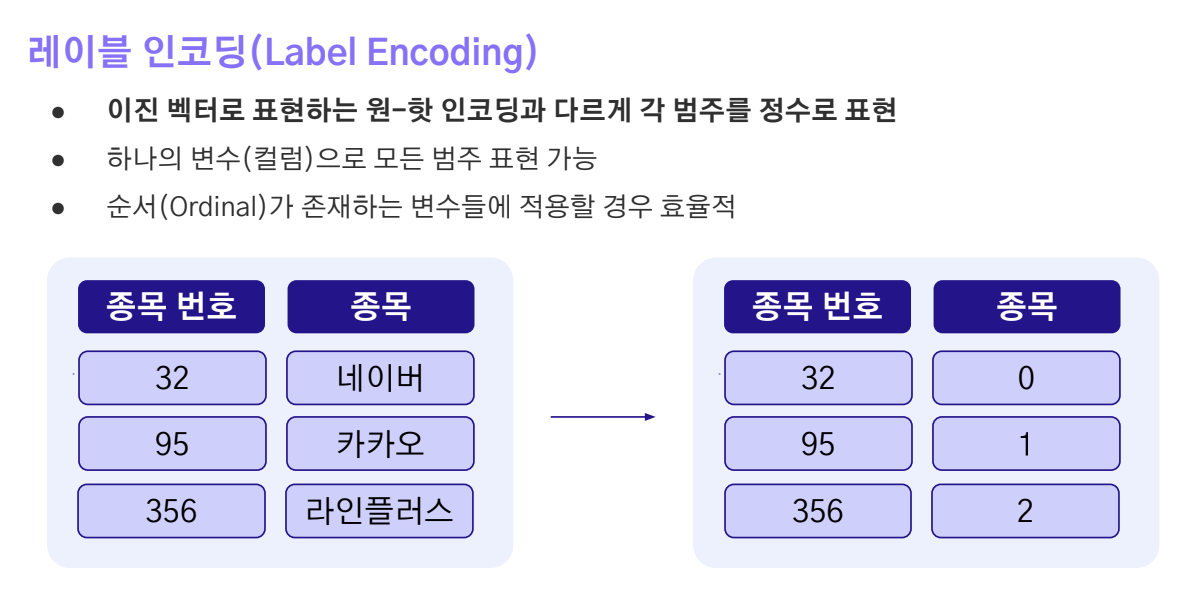

In [67]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '강남여부', '가격상승률', '동등급', '한강근접여부', '지하철거리', '기준금리', '신축여부']
범주형 변수: ['본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '단지신청일', '구', '동', '계약년', '계약월', '평형대', '학군']


In [68]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


In [69]:
continuous_columns_v2

['전용면적',
 '층',
 '건축년도',
 'k-전체동수',
 'k-전체세대수',
 'k-연면적',
 'k-주거전용면적',
 'k-관리비부과면적',
 'k-전용면적별세대현황(60㎡이하)',
 'k-전용면적별세대현황(60㎡~85㎡이하)',
 'k-85㎡~135㎡이하',
 '건축면적',
 '주차대수',
 '좌표X',
 '좌표Y',
 'target',
 '강남여부',
 '가격상승률',
 '동등급',
 '한강근접여부',
 '지하철거리',
 '기준금리',
 '신축여부']

In [70]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,계약월,강남여부,평형대,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부
0,1114,1,293,79.97,3,1987,5520,3,2,2,...,11,1,2,1.185023,1,2,9,0.999526,1.5,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [71]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [72]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [73]:
import xgboost

model=xgboost.XGBRegressor(
    device='gpu'
)

### 하이퍼파라미터 탐색을 위한 코드

- GridSearch와 RandomSearch 중 선택을 고민했습니다
- GridSearch는 모든 경우의 수를 따져서 시간이 많이 소요되므로 RandomSearch 를 선택했습니다.
- 최적의 하이퍼파라미터를 이미 찾아 아래 코드에서 사용하고있으니 앞으로 실행할 필요는 없습니다.

In [74]:

# base_score=[0.25,0.5,0.7]

# n_estimators = [500, 1000, 1500, 2000]
# max_depth = [3, 5, 7, 10]
# booster=['gbtree']
# learning_rate=[0.01, 0.03, 0.05, 0.1]
# min_child_weight=[1, 5, 10]

# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight,
#     'booster':booster,
#     'base_score':base_score
#     }

# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = -1,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)


In [75]:
# random_cv.fit(X_train, y_train)

In [76]:
# random_cv.best_params_

In [77]:
# random_cv.best_score_

### 하이퍼파라미터 선택지들

* 현재까지 파악된 제일 좋은 점수를 보이는 하이퍼파라미터는 learningRate=0.05, n_estimator=5000 입니다.
* 하지만 n_estimator변수의 값이 높으면 과적합 우려가 있습니다.
* 추후 EDA가 완료된 후 n_estimator값이 낮은 모델로도 학습 후 테스트가 필요합니다.

각 하이퍼파라미터별로 상단에 점수를 기재해두었습니다.


In [78]:
#44490
# n_estimators가 작다
# EDA가 완료된 후 아래 파라미터로도 학습 후 테스트가 필요요
# model=xgboost.XGBRegressor(
#  n_estimators= 900,
#  learning_rate= 0.15,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.25)
 
# 45045.5677
# model=xgboost.XGBRegressor(
#  n_estimators= 1500,
#  learning_rate= 0.1,
#  max_depth= 10,
#  min_child_weight= 1,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43815.4360
# RMSE test: 4280.667057047746
# model=xgboost.XGBRegressor(
#  n_estimators= 2000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43752.7333
# RMSE test: 4226.164120555658
# model=xgboost.XGBRegressor(
#  n_estimators= 3000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

### 모델

In [79]:
# 현재까지 제일 성능이 좋은 하이퍼파라미터 입니다.
# n_estimators가 꽤 큰값이라 과적합 우려가 있습니다다.
# EDA가 끝나고 n_estimator가 작은 하이퍼파라미터로 학습을 시키고 점수를 비교해봐야 합니다.
# 43735.7052
# RMSE test: 4206.333504214999
model=xgboost.XGBRegressor(
 n_estimators= 500,
 learning_rate= 0.05,
 max_depth= 10,
 min_child_weight= 5,
 booster= 'gbtree',
 device='cuda',
 base_score= 0.5)

In [80]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
pred = model.predict(X_val)

~~- 포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다~~

In [82]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

# n_estimators = 4000 : 
# n_estimators = 3000 : 
# n_estimators = 2000 : 
# n_estimators = 1000 : 1072.9408201833169
# n_estimators = 500 : 
    # learning_rate= 0.1 : 
    # learning_rate= 0.06 : 1139.4134303625754  <<<<
    # learning_rate= 0.05 : 
    # learning_rate= 0.01 : 
# n_estimators = 250 : 


RMSE test: 1013.6908512960134


- 변수 중요도도 확인해보도록 하겠습니다.

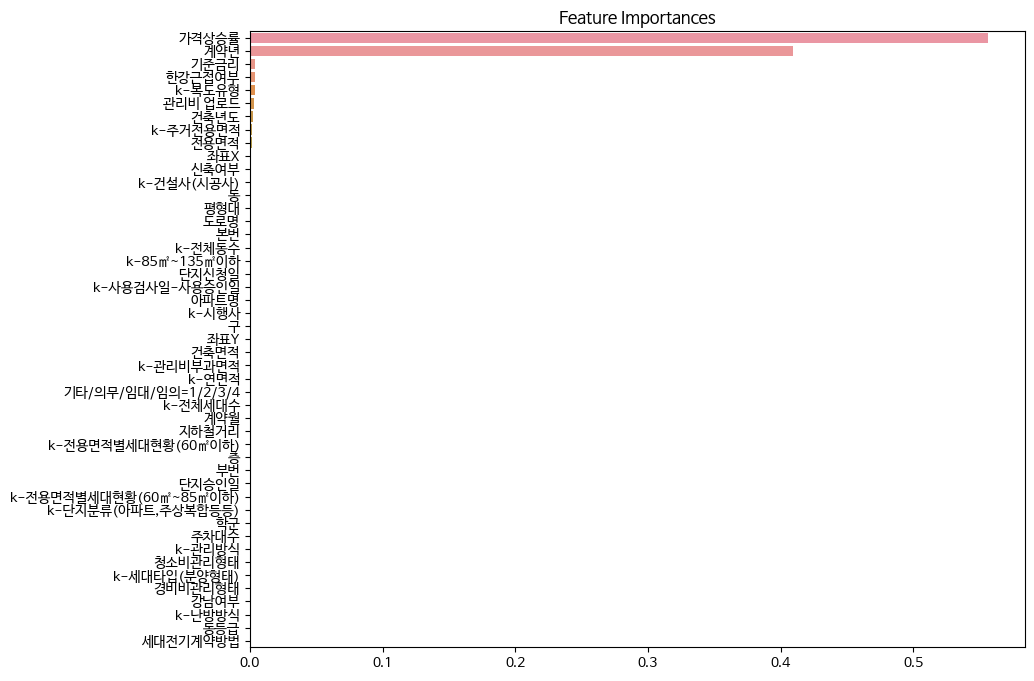

In [83]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [84]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [85]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=len(X_val.columns))    # valid data에 대해 적합시킵니다.

Weight,Feature
1862093759.5410 ± 11215974.9066,가격상승률
809345553.4451 ± 4198206.6909,계약년
2797018.1965 ± 121232.4737,전용면적
1245234.9232 ± 3313.5765,건축년도
1068095.0824 ± 64643.4209,기준금리
270125.2882 ± 47898.1354,계약월
190213.0619 ± 44770.2344,k-주거전용면적
126501.2261 ± 8062.2310,한강근접여부
122950.7138 ± 38342.2720,도로명
110089.5290 ± 3091.6627,아파트명


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [86]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [87]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038846 entries, 0 to 9271
Data columns (total 49 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   본번                      1038846 non-null  object  
 1   부번                      1038846 non-null  object  
 2   아파트명                    1038846 non-null  object  
 3   전용면적                    1038846 non-null  float64 
 4   층                       1038846 non-null  int64   
 5   건축년도                    1038846 non-null  int64   
 6   도로명                     1038846 non-null  object  
 7   k-단지분류(아파트,주상복합등등)      1038846 non-null  object  
 8   k-세대타입(분양형태)            1038846 non-null  object  
 9   k-관리방식                  1038846 non-null  object  
 10  k-복도유형                  1038846 non-null  object  
 11  k-난방방식                  1038846 non-null  object  
 12  k-전체동수                  1038846 non-null  float64 
 13  k-전체세대수                 1038846 non-null  flo

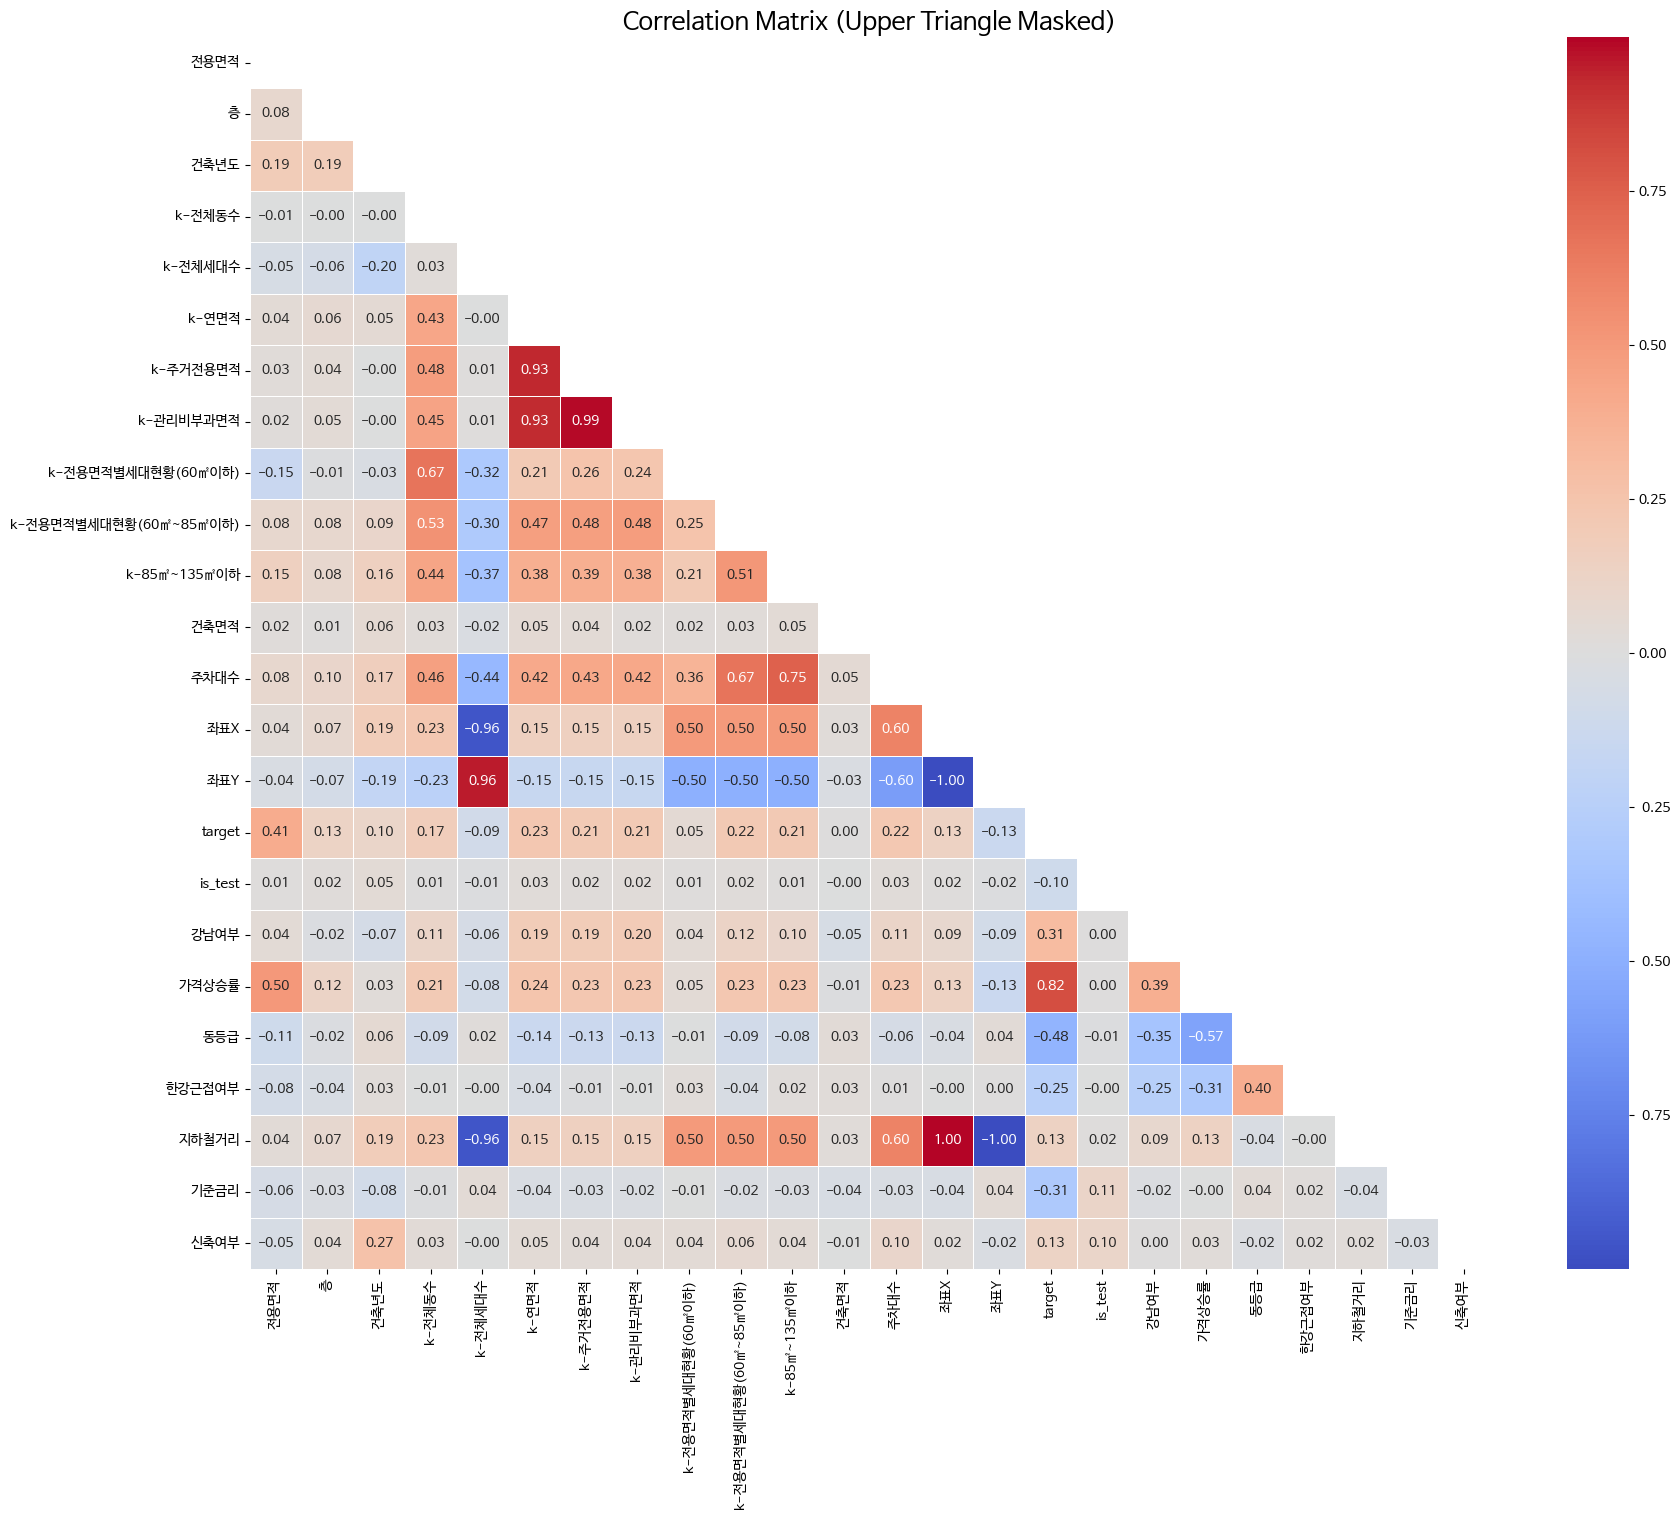

In [88]:
# 상관행렬 계산
correlation_matrix = concat_select.corr()

# 상삼각 행렬의 중복 부분 제거를 위한 마스크 생성
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 히트맵 시각화 (중복 제거)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Matrix (Upper Triangle Masked)", fontsize=18)
plt.show()

In [89]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [90]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [91]:
X_val_sort.head()

,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
58002,164,0,5327,122.10,2,1982,5031,0,0,0,...,4.813469,1,1,9,0.000038,1.50,0,350000.0,225245.703125,1.556363e+10
232345,422,0,3332,114.94,8,2018,6702,3,1,1,...,3.833716,1,1,9,0.999061,1.50,1,470000.0,371297.000000,9.742282e+09
354489,1223,0,2080,104.89,5,1973,5027,0,0,0,...,2.598180,1,1,9,0.000038,1.25,0,274677.0,364558.843750,8.078746e+09
223709,32,0,1518,114.15,2,2015,3990,0,0,0,...,4.018837,1,2,9,0.000057,1.50,0,488000.0,416231.031250,5.150785e+09
230635,542,1,1572,117.12,24,2009,3383,3,1,1,...,3.363420,1,1,9,0.999057,0.75,0,425000.0,492312.125000,4.530922e+09


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [92]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [93]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [94]:
display(error_top100.head(5))
display(best_top100.head(1))

,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
58002,12.0,0.0,한신15차,122.10,2,1982,신반포로15길 5,NULL,NULL,NULL,...,4.813469,1,1,8학군,0.000038,1.50,0,350000.0,225245.703125,1.556363e+10
232345,160.0,0.0,신반포자이,114.94,8,2018,잠원로 60,아파트,기타,위탁관리,...,3.833716,1,1,8학군,0.999061,1.50,1,470000.0,371297.000000,9.742282e+09
354489,757.0,0.0,반포주공1단지,104.89,5,1973,신반포로 9,NULL,NULL,NULL,...,2.598180,1,1,8학군,0.000038,1.25,0,274677.0,364558.843750,8.078746e+09
223709,1027.0,0.0,래미안대치팰리스,114.15,2,2015,삼성로51길 37,NULL,NULL,NULL,...,4.018837,1,2,8학군,0.000057,1.50,0,488000.0,416231.031250,5.150785e+09
230635,18.0,1.0,래미안퍼스티지,117.12,24,2009,반포대로 275,아파트,기타,위탁관리,...,3.363420,1,1,8학군,0.999057,0.75,0,425000.0,492312.125000,4.530922e+09


,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
1009250,103.0,5.0,청원파크빌3,77.27,2,2006,천중로56길 41,NULL,NULL,NULL,...,-0.225596,2,2,6학군,0.000026,5.0,0,23000.0,22999.960938,0.001526


- 이제 분포를 비교해보도록 하겠습니다.

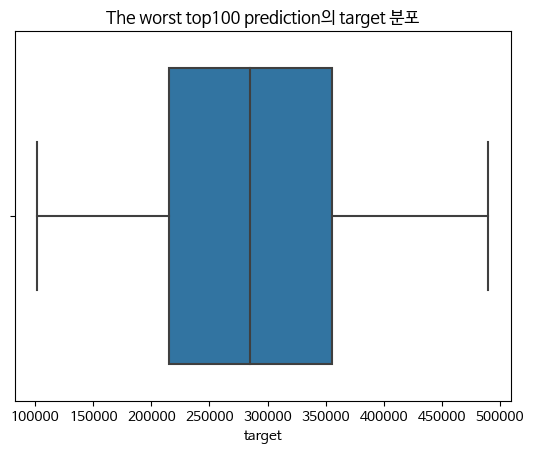

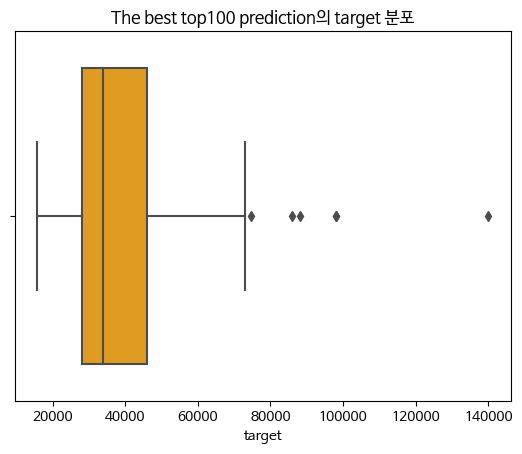

In [95]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

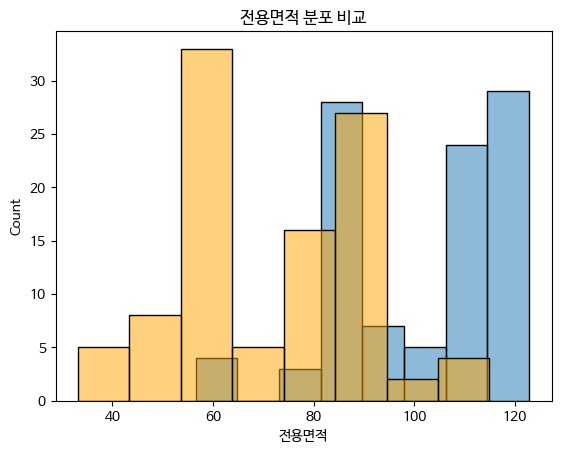

In [96]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [97]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,...,계약월,강남여부,평형대,가격상승률,동등급,한강근접여부,학군,지하철거리,기준금리,신축여부
0,1114,1,293,79.9700,5,1987,5520,3,2,2,...,6,1,2,0.501223,1,2,9,0.999526,3.5,0
1,1107,1,294,108.2017,10,2021,431,3,2,1,...,7,1,0,0.501223,1,2,9,0.999476,3.5,1


In [98]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [99]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 135 ms, sys: 4.5 ms, total: 140 ms
Wall time: 29.3 ms


In [100]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([151589.83, 151657.03, 152352.19, ...,  83517.38,  83508.27,
        83508.67], dtype=float32)

## 7. Output File Save

In [101]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [102]:
concat_select.isnull().sum()

본번                        0
부번                        0
아파트명                      0
전용면적                      0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                    0
is_test             